This notebook provides the code to calculate and visualize some of the basic microbiome data analyses you can do.

In [153]:
#First, import the python packages you'll need

import pandas as pd # for dataframes
import numpy as np # for handling floats and matrices

import matplotlib.pyplot as plt # base plotting package
import seaborn as sns # ggplot-like plotting package

# scikit bio functions
import skbio.diversity.alpha as alph # alpha diversity
from skbio.diversity import beta_diversity # beta diversity

# stats
from scipy.stats.mstats import kruskalwallis # differential abundance
from statsmodels.sandbox.stats.multicomp import multipletests # multiple test correction
from scipy.stats import spearmanr

# Download data

First, we'll download an example OTU table from MicrobiomeHD on Zenodo (https://zenodo.org/record/1146764). 

In [101]:
%%bash

# make target directory for data
mkdir data

# download data from zenodo with wget
# only download if file doesn't exist
if [ ! -f "data/cdi_schubert_results.tar.gz" ]
then
wget -O data/cdi_schubert_results.tar.gz https://zenodo.org/record/1146764/files/cdi_schubert_results.tar.gz --no-check-certificate
# untar directory (like unzipping)
tar -C data/ -xvf data/cdi_schubert_results.tar.gz
fi



mkdir: data: File exists
--2019-04-05 11:18:22--  https://zenodo.org/record/1146764/files/crc_baxter_results.tar.gz
Resolving zenodo.org... 137.138.76.77
Connecting to zenodo.org|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17703967 (17M) [application/octet-stream]
Saving to: ‘data/crc_baxter_results.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  161K 1m47s
    50K .......... .......... .......... .......... ..........  0% 5.42M 55s
   100K .......... .......... .......... .......... ..........  0%  494K 48s
   150K .......... .......... .......... .......... ..........  1% 16.4M 36s
   200K .......... .......... .......... .......... ..........  1%  453K 36s
   250K .......... .......... .......... .......... ..........  1% 81.2M 30s
   300K .......... .......... .......... .......... ..........  2%  560K 30s
   350K .......... .......... .......... .......... ..........  2% 21.5M 26s
   400K .......... .........

In [162]:
%%bash
# Download CRC Baxter

# make target directory for data
mkdir data

# download data from zenodo with wget
# only download if file doesn't exist
if [ ! -f "data/crc_baxter_results.tar.gz" ]
then
wget -O data/crc_baxter_results.tar.gz https://zenodo.org/record/1146764/files/crc_baxter_results.tar.gz --no-check-certificate
# untar directory (like unzipping)
tar -C data/ -xvf data/crc_baxter_results.tar.gz
fi



mkdir: data: File exists


## Read in data

Next, we'll read in the data. These OTU tables are tab-separated.

In [159]:
fname_otu = 'data/cdi_schubert_results/RDP/cdi_schubert.otu_table.100.denovo.rdp_assigned'
fname_meta = 'data/cdi_schubert_results/cdi_schubert.metadata.txt'

df = pd.read_csv(fname_otu, sep='\t', index_col=0)
# need to transpose df so OTUs are in columns (this is my personal preference)
df = df.T
meta = pd.read_csv(fname_meta, sep='\t', index_col=0)

df.shape, meta.shape

((347, 19314), (337, 49))

Clean up the OTU table a bit -- it looks like there's 347 samples in the OTU table but only 337 in the metadata. We'll just keep the samples that are in both.

In [160]:
# get samples that are in both tables
keep_samples = [i for i in meta.index if i in df.index]
print(len(keep_samples))

# subset the tables to only keep those samples
df = df.loc[keep_samples]
meta = meta.loc[keep_samples]

print(df.shape, meta.shape)

336
((336, 19314), (336, 49))


In [163]:
# Read in Baxter data
fname_otu = 'data/crc_baxter_results/RDP/crc_baxter.otu_table.100.denovo.rdp_assigned'
fname_meta = 'data/crc_baxter_results/crc_baxter.metadata.txt'

df_baxt = pd.read_csv(fname_otu, sep='\t', index_col=0)
# need to transpose df so OTUs are in columns (this is my personal preference)
df_baxt = df_baxt.T
meta_baxter = pd.read_csv(fname_meta, sep='\t', index_col=0)

df_baxt.shape, meta_baxter.shape

((490, 122510), (490, 72))

# Basic checks

In [173]:
ax[0].get_xticks()

array([2.5, 3. , 3.5, 4. , 4.5])

Text(0.5,0,'log10(reads)')

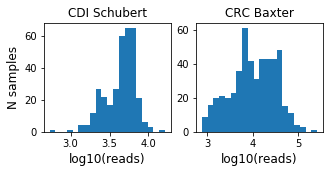

In [179]:
# Reads per sample
fig, ax = plt.subplots(1, 2, figsize=(5, 2))

ax[0].hist(np.log10(df.sum(axis=1)), bins=20)
ax[0].set_title('CDI Schubert')
ax[0].set_ylabel('N samples', fontsize='large')
ax[0].set_xlabel('log10(reads)', fontsize='large')

ax[1].hist(np.log10(df_baxt.sum(axis=1)), bins=20)
ax[1].set_title('CRC Baxter')
ax[1].set_xlabel('log10(reads)', fontsize='large')


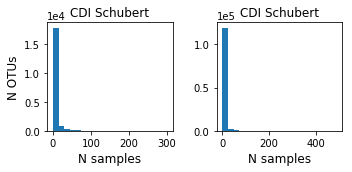

In [200]:
# OTUs distribution - before removing OTUs with few reads
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))

a = ax[0]
a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
a.hist((df > 0).sum(), bins=20)
a.set_xlabel('N samples', fontsize='large')
a.set_ylabel('N OTUs', fontsize='large')
a.set_title('CDI Schubert')

a = ax[1]
a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
a.hist((df_baxt > 0).sum(), bins=20)
a.set_xlabel('N samples', fontsize='large')
a.set_title('CDI Schubert')

fig.tight_layout()

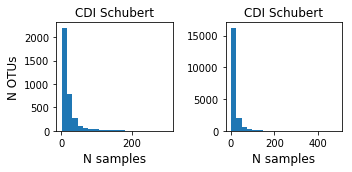

In [202]:
# Distribution of OTUs, after removing OTUs with fewer than 10 reads total
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))

a = ax[0]
#a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
a.hist((df.loc[:, df.sum() > 10] > 0).sum(), bins=20)
a.set_xlabel('N samples', fontsize='large')
a.set_ylabel('N OTUs', fontsize='large')
a.set_title('CDI Schubert')

a = ax[1]
#a.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
a.hist((df_baxt.loc[:, df_baxt.sum() > 10] > 0).sum(), bins=20)
a.set_xlabel('N samples', fontsize='large')
a.set_title('CDI Schubert')

fig.tight_layout()

# Alpha diversity

First, we'll show a toy example demonstrating samples with different evenness and richness.

Then we'll calculate alpha diversity on real data.

[Text(0,0,u'A'), Text(0,0,u'B'), Text(0,0,u'C')]

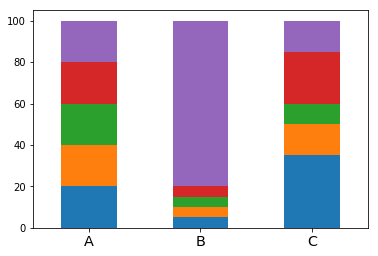

In [38]:
toy_alpha =  {'otu1': [0.2, 0.05, 0.35],
              'otu2': [0.2, 0.05, 0.15],
              'otu3': [0.2, 0.05, 0.10],
              'otu4': [0.2, 0.05, 0.25],
              'otu5': [0.2, 0.80, 0.15]}

toy_alpha = pd.DataFrame(toy_alpha, index=['A', 'B', 'C'])
# Convert to absolute counts for later calculations
toy_alpha = (toy_alpha*100).astype(int)

# Plot
ax = toy_alpha.plot(kind='bar', stacked=True, legend=False, rot=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')

In [49]:
# Calculate alpha diversities for these three samples

lst_alpha = []

alpha_funs = {'shannon': alph.shannon,
              'chao1': alph.chao1,
              'simpson': alph.simpson_e}

for metric in ['shannon', 'chao1', 'simpson']:

    alphafun = alpha_funs[metric]
    tmp = pd.DataFrame(toy_alpha.apply(alphafun, axis=1))
    tmp['metric'] = metric
    lst_alpha.append(tmp)
    
# Concatenate all three alpha diversities
alphadf = pd.concat(lst_alpha).reset_index()
alphadf.columns = ['sample', 'alpha', 'metric']
alphadf.pivot(index='sample', columns='metric')

alpha                    
metric chao1   shannon   simpson
sample                          
A        5.0  2.321928  1.000000
B        5.0  1.121928  0.307692
C        5.0  2.183383  0.833333

# Beta diversity and PCA

I'll be using code from a previously published paper for this figure, but here's some toy code to get you started.

You can find the list of all beta-diversity distance metrics implemented on the [scipy pdist documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist).

In [59]:
metric = 'braycurtis'
beta_div = beta_diversity(metric, df.values, ids=df.index)

There are two ways to use beta diversity results.

One is in wide form, where the rows and columns are samples and the values are the distance between those two samples. This is the form you need as an input for things like PCA, and can be thought of as a distance matrix.

In [65]:
# Convert to redundant, wide format
widebeta = pd.DataFrame(beta_div.redundant_form(),
    index=df.index, columns=df.index)

widebeta.head()

,DA00006,DA00044,DA00065,DA00108,DA00153,DA00154,DA00155,DA00165,DA00170,DA00210,...,DA10178,DA10180,DA10181,DA10182,DA10183,DA10184,DA10186,DA10187,DA10188,DA10189
DA00006,0.000000,0.923267,0.995494,0.700953,0.990916,0.941623,0.763016,0.981542,0.822233,0.731186,...,0.999275,0.995497,0.996361,0.998620,0.996667,0.960602,0.989040,0.999415,1.000000,0.989936
DA00044,0.923267,0.000000,0.995932,0.999442,0.983801,0.960086,0.986601,0.997254,0.999474,0.925584,...,0.999601,0.999496,0.995739,0.999267,0.994922,0.996083,0.999202,0.995262,0.999007,0.998678
DA00065,0.995494,0.995932,0.000000,0.717244,0.916667,0.920671,0.980210,0.779170,0.747336,0.848231,...,0.774616,0.737636,0.718671,0.613213,0.774742,0.754574,0.583980,0.620942,0.908685,0.771414
DA00108,0.700953,0.999442,0.717244,0.000000,0.960593,0.943463,0.735849,0.827455,0.697003,0.556464,...,0.941335,0.842741,0.852401,0.833198,0.912482,0.846947,0.821149,0.790526,0.939989,0.935760
DA00153,0.990916,0.983801,0.916667,0.960593,0.000000,0.936345,0.948343,0.839228,0.889554,0.901318,...,0.842186,0.939400,0.933742,0.918158,0.922274,0.923199,0.924961,0.866599,0.919914,0.911738


Alternatively, you can convert distance matrices to tidy format, where each row contains at least the following values: [sample1, sample2, distance between sample1 and 2]. This is helpful to add columns which indicate certain metadata variables and makes it easier to make plots, in my opinion. Here's some code I've used to convert the wide beta diversity dataframe into tidy format. There are probably better ways, maybe.

In [66]:
## Convert to long-form, tidy format
widebeta.index.name = 'sample1'
# Remove redundant comparisons before converting to tidy.
# k=1 removes the diagonal, so we don't keep the self-self comparisons
betadf = widebeta.where(np.triu(np.ones(widebeta.shape, dtype=bool), k=1))

betadf = pd.melt(betadf.reset_index(),
    id_vars='sample1', var_name='sample2', value_name='beta')
betadf = betadf.dropna()
betadf.head()

,sample1,sample2,beta
336,DA00006,DA00044,0.923267
672,DA00006,DA00065,0.995494
673,DA00044,DA00065,0.995932
1008,DA00006,DA00108,0.700953
1009,DA00044,DA00108,0.999442


This is helpful because now you can add metadata and make interesting comparisons.

In [73]:
betadf['disease1'] = betadf['sample1'].apply(lambda x: meta.loc[x, 'DiseaseState'])
betadf['disease2'] = betadf['sample2'].apply(lambda x: meta.loc[x, 'DiseaseState'])
betadf['disease_comparison'] = betadf['disease1'] + '-' + betadf['disease2']
betadf.head()

,sample1,sample2,beta,disease1,disease2,disease_comparison
336,DA00006,DA00044,0.923267,nonCDI,CDI,nonCDI-CDI
672,DA00006,DA00065,0.995494,nonCDI,CDI,nonCDI-CDI
673,DA00044,DA00065,0.995932,CDI,CDI,CDI-CDI
1008,DA00006,DA00108,0.700953,nonCDI,nonCDI,nonCDI-nonCDI
1009,DA00044,DA00108,0.999442,CDI,nonCDI,CDI-nonCDI


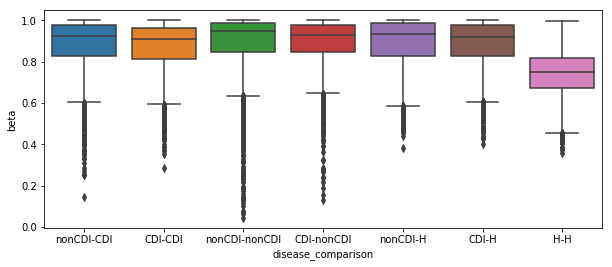

In [75]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=betadf, x='disease_comparison', y='beta', ax=ax)

Voila! So easy!

# Differential abundance


In [77]:
h_smpls = meta.query('DiseaseState == "H"').index.tolist()
cdi_smpls = meta.query('DiseaseState == "CDI"').index.tolist()
print(len(h_smpls), len(cdi_smpls))

(154, 93)


In [90]:
## Prepare dataframe that we'll use for testing

# keep only healthe and CDI samples
abundf = df.loc[h_smpls + cdi_smpls]

# Keep only OTUs with more than 10 reads
abundf = abundf.loc[:, abundf.sum() > 10]

# convert to relative abundance
abundf = abundf.divide(abundf.sum(axis=1), axis=0)

print(abundf.shape)

(247, 3043)


In [91]:
# Still haven't figured out how to vectorize this, womp
lst_pvals = []
for o in abundf.columns:
    try:
        h, p = kruskalwallis(abundf.loc[h_smpls, o].values, abundf.loc[cdi_smpls, o].values)
    except ValueError:
        # If all numbers are zero, kruskal wallis breaks
        p = np.nan
        h = np.nan
    lst_pvals.append([o, h, p])

In [94]:
# Put results into dataframe
pvalsdf = pd.DataFrame(data=lst_pvals, columns=['otu', 'test_stat', 'p'])

# correct for multiple tests
_, pvalsdf['q'], _, _ = multipletests(pvalsdf['p'], method='fdr_bh')

In [95]:
pvalsdf.sort_values(by='q').head()

,otu,test_stat,p,q
10,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,128.608540,8.260417e-30,2.513645e-26
2595,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,117.589884,2.132153e-27,3.244071e-24
1836,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,110.137254,9.143543e-26,9.274601e-23
2583,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,103.447781,2.673486e-24,2.033855e-21
2587,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,100.069446,1.471461e-23,8.955313e-21


(array([1710.,  389.,  257.,  192.,  221.,   68.,   61.,   47.,   65.,
          33.]),
 array([2.51364478e-26, 9.95217973e-02, 1.99043595e-01, 2.98565392e-01,
        3.98087189e-01, 4.97608987e-01, 5.97130784e-01, 6.96652581e-01,
        7.96174379e-01, 8.95696176e-01, 9.95217973e-01]),
 <a list of 10 Patch objects>)

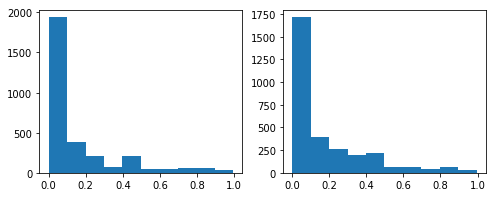

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(pvalsdf['p'])
ax[1].hist(pvalsdf['q'])

Note: usually the p-value histograms will look _very_ different from this, with a much smaller peak at low p-values. It's so skewed here because diarrhea changes the abundance of most bugs. If I have time, I'll repeat this analysis with the CRC Baxter data, which has far fewer signifcant differences. 

In [139]:
meta.columns

Index([u'submitted_to_insdc', u'investigation_type', u'project_name',
       u'experimental_factor', u'lat_lon', u'geo_loc_name', u'biome',
       u'feature', u'material', u'env_package', u'samp_collect_device',
       u'samp_mat_process', u'samp_size', u'nucl_acid_ext', u'nucl_acid_amp',
       u'lib_reads_seqd', u'lib_const_meth', u'target_gene',
       u'target_subfragment', u'sfffile_id', u'pcr_primers', u'mid',
       u'adapters', u'pcr_cond', u'seq_meth', u'seq_qual_check',
       u'chimera_check', u'url', u'sop', u'host_common_name', u'age', u'race',
       u'gender', u'antibiotics >3mo', u'protonpump', u'h2receptor',
       u'antacid', u'Healthworker', u'historyCdiff', u'Surgery6mos',
       u'Vegetarian', u'ResidenceCdiff', u'weight', u'disease_stat',
       u'body_product', u'tot_mass', u'perturbation', u'samp_store_temp',
       u'DiseaseState'],
      dtype='object')

In [125]:
# Plot differentially abundant bugs
otus = pvalsdf.sort_values(by='q')['otu'][:12].values
sigdf = abundf[otus]

# convert to tidy format
sigdf = sigdf.reset_index().melt(id_vars='sample1', var_name='otu', value_name='abun')

# combine with disease metadata
sigdf = pd.merge(
    sigdf, meta[['DiseaseState', 'age', 'race', 'gender']], 
    left_on='sample1', right_index=True, 
    how='left')

# make a shorter OTU name for plotting
sigdf['short_otu'] = sigdf['otu'].str.split(';', 5).str[-1]

sigdf.head()

,sample1,otu,abun,DiseaseState,age,race,gender,short_otu
0,DA10002,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,H,28.0,white,M,g__Clostridium_XI;s__;d__denovo54
1,DA10003,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,H,64.0,white,F,g__Clostridium_XI;s__;d__denovo54
2,DA10005,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,H,66.0,white,F,g__Clostridium_XI;s__;d__denovo54
3,DA10006,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,H,74.0,white,F,g__Clostridium_XI;s__;d__denovo54
4,DA10007,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,H,33.0,white,F,g__Clostridium_XI;s__;d__denovo54


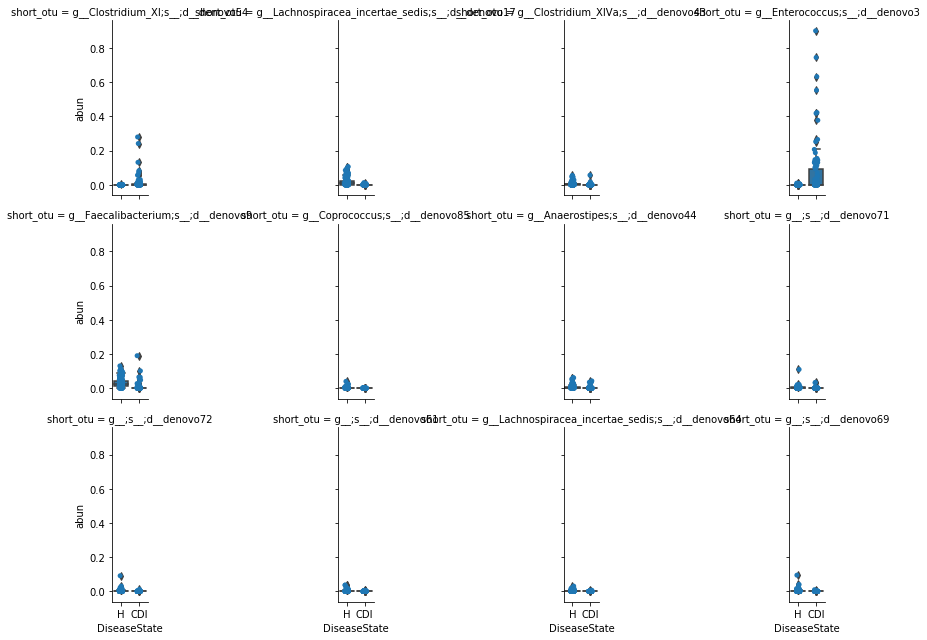

In [127]:
# And now plot with FacetGrid
order = ['H', 'CDI']

g = sns.FacetGrid(data=sigdf, col='short_otu', col_wrap=4)
g.map(sns.boxplot, 'DiseaseState', 'abun', order=order)
g.map(sns.stripplot, 'DiseaseState', 'abun', dodge=True, order=order)

So you can see that FacetGrid sometimes doesn't play nice with long titles. We'll just make two plots for now

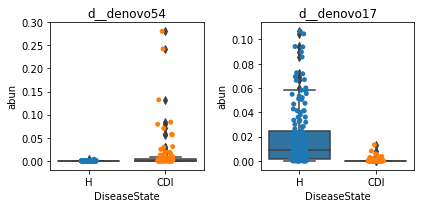

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
order = ['H', 'CDI']

o = otus[0]
a = ax[0]

sns.boxplot(
    data=sigdf.query('otu == @o'), 
    x='DiseaseState', y='abun', 
    order=order, ax=a)
sns.stripplot(
    data=sigdf.query('otu == @o'), 
    x='DiseaseState', y='abun', 
    order=order, dodge=True, ax=a)

a.set_title(o.rsplit(';', 1)[-1])

o = otus[1]
a = ax[1]

sns.boxplot(
    data=sigdf.query('otu == @o'), 
    x='DiseaseState', y='abun', 
    order=order, ax=a)
sns.stripplot(
    data=sigdf.query('otu == @o'), 
    x='DiseaseState', y='abun', 
    order=order, dodge=True, ax=a)

a.set_title(o.rsplit(';', 1)[-1])

fig.tight_layout()

# Correlate alpha diversity with metadata

We'll calculate alpha diversity for our CDI Schubert samples and correlate it with age.

In [142]:
# Calculate alpha diversity
alphadf = df.apply(alph.shannon, axis=1).reset_index()
alphadf.columns = ['sample', 'alpha']

# Merge with metadata
metacols = ['gender', 'antibiotics >3mo', 'protonpump', 'h2receptor',
            'antacid', 'Healthworker', 'historyCdiff', 'Surgery6mos',
            'Vegetarian', 'ResidenceCdiff', 'weight', 'disease_stat',
            'body_product', 'age', 'race']

alphadf = pd.merge(
    alphadf, meta[metacols],
    left_on='sample', right_index=True,
    how='left')

alphadf.head()

,sample,alpha,gender,antibiotics >3mo,protonpump,h2receptor,antacid,Healthworker,historyCdiff,Surgery6mos,Vegetarian,ResidenceCdiff,weight,disease_stat,body_product,age,race
0,DA00006,2.857288,M,yes,no,no,no,no,no,yes,no,no,200-249,DiarrhealControl,feces,68.0,white
1,DA00044,2.421233,M,yes,yes,no,yes,no,no,yes,no,no,Unknown,Case,feces,60.0,white
2,DA00065,3.618504,F,yes,no,no,no,no,no,yes,no,no,Unknown,Case,feces,72.0,white
3,DA00108,2.760812,M,yes,no,no,no,no,no,no,no,no,150-199,DiarrhealControl,feces,61.0,white
4,DA00153,5.365275,F,no,no,no,no,no,no,no,no,no,100-149,DiarrhealControl,feces,85.0,white


Text(0,0.5,'Age')

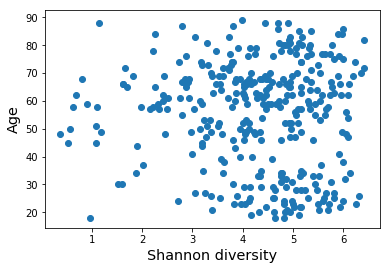

In [152]:
fig, ax = plt.subplots()

ax.scatter(alphadf['alpha'], alphadf['age'])

ax.set_xlabel('Shannon diversity', fontsize='x-large')
ax.set_ylabel('Age', fontsize='x-large')


In [154]:
# Calculate correlation
spearmanr(alphadf['alpha'], alphadf['age'])

SpearmanrResult(correlation=-0.026529849224738687, pvalue=0.6279791178692606)